In [1]:
import sim
import util
import synthetics
import numpy as np
import utilities
from IPython.display import clear_output
from models import GibbsSLDA, GibbsLDA

clear_output()

In [63]:
np.random.choice(5, 3)

array([0, 3, 0])

In [64]:
def generate_datasets(n_sections, n_genes, n_informative, n_cells=900, n_topics=2, blocks=None, mode=None, mixed=False, means=None, variances=None, x_max=30, y_max=30):
    args = tuple(locals().values())[1:]

    if means is None:
        means, variances = synthetics.generate_means(n_genes, n_informative, max(n_topics))
    sections, labels = [], []

    for i in range(len(mode)):
        # idx = np.random.permutation(max(n_topics))[:n_topics[i]]
        idx = np.random.choice(max(n_topics), n_topics[i])
        m = means[idx]
        dataset, label = synthetics.generate_dataset(n_genes, n_informative, n_cells[i], n_topics[i], blocks[i], mode[i], mixed, m, variances, x_max, y_max)
        dataset = np.concatenate([np.ones((dataset.shape[0], 1))*i, dataset], -1)
        sections.append(dataset)
        for j in range(len(label)):
            label[j] = idx[label[j]]
        labels.append(label)

    datasets = np.stack(sections)
    labels = np.stack(labels)

    return datasets, labels

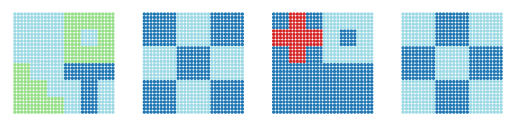

In [73]:
N_GENES = 1000
N_INFORMATIVE = 1000
N_CELLS = [1, 1, 1, 1]
N_TOPICS = [5, 2, 5, 2]
MODE = ['block', 'block', 'block', 'block']
BLOCKS = [synthetics.GGBLOCKS, synthetics.CHBLOCKS, synthetics.GGBLOCKS, synthetics.CHBLOCKS]
MIXED = False

datasets, labels = generate_datasets(3, N_GENES, N_INFORMATIVE, N_CELLS, N_TOPICS, BLOCKS, MODE, MIXED)
N_IMGS, N_SAMPLES, N_FEATURES = datasets.shape
X = np.zeros((N_IMGS*N_SAMPLES, N_FEATURES))
X_labels = np.zeros(N_IMGS*N_SAMPLES, dtype=np.int32)
# X_idx = np.ones((N_IMGS*N_SAMPLES, 1))
for i in range(N_IMGS):
    j, k = i*N_SAMPLES, (i + 1)*N_SAMPLES
    X[j:k], X_labels[j:k] = datasets[i], labels[i]
    # X_idx[j:k] = i + 1
# X = np.concatenate([X_idx, X], -1)
utilities.visualize_datasets(datasets, X_labels.reshape(N_IMGS, N_SAMPLES), size=2, show_ax=False)

100%|██████████| 400/400 [01:16<00:00,  5.21it/s]


Score: 1.0


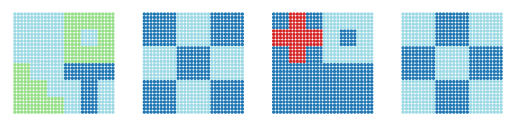

In [74]:
N_STEPS = N_IMGS*100
N_DOCS = 150
VOCAB_SIZE = 15
SIGMA = .01

model = GibbsSLDA(5, N_DOCS, VOCAB_SIZE, sigma=SIGMA)
labels = model.fit_transform(X, N_STEPS)
Y_labels, score = util.evaluate(X_labels, labels)
print('Score:', score)
utilities.visualize_datasets(datasets, Y_labels.reshape(N_IMGS, N_SAMPLES), size=2, show_ax=False)

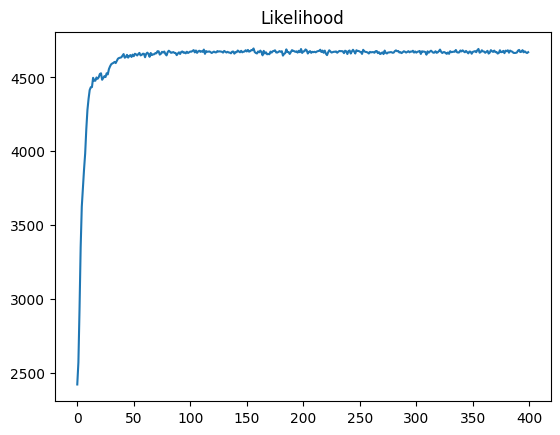

In [75]:
util.visualize_log(model.likelihood_log_, 'Likelihood')

## Synthetic Data

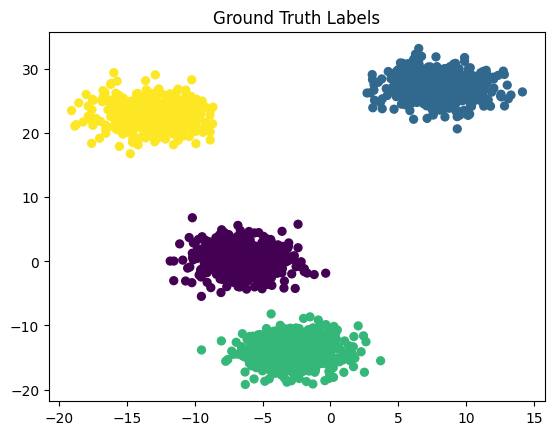

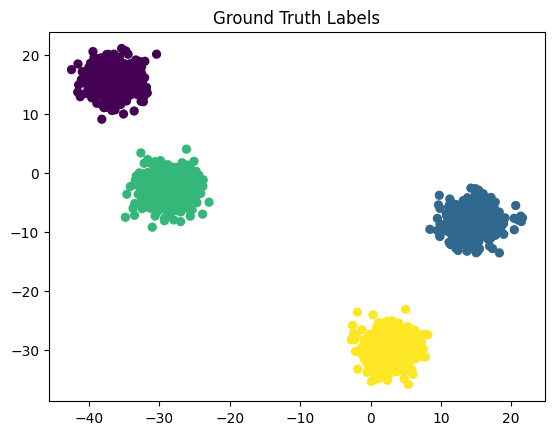

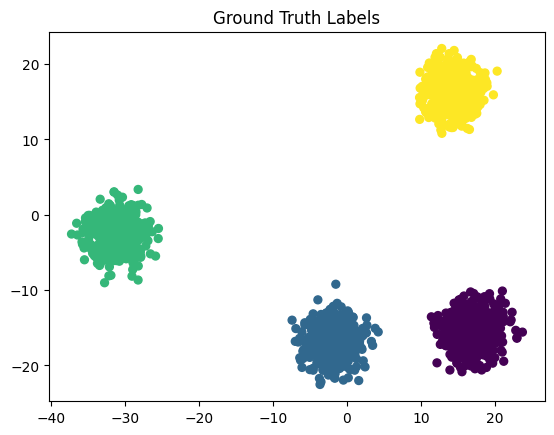

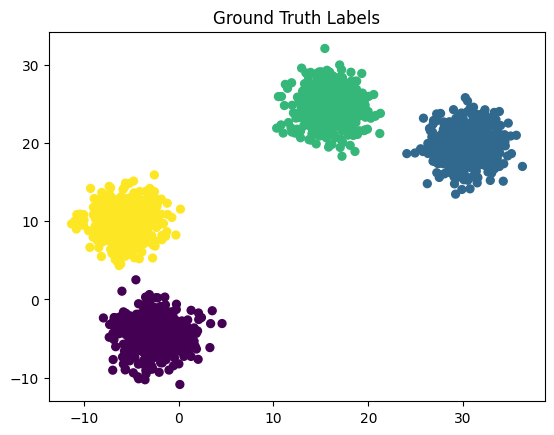

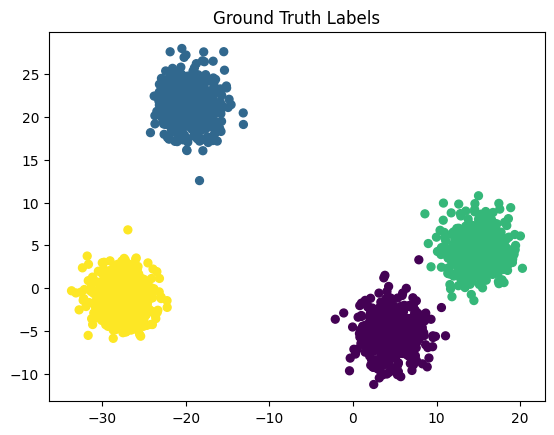

In [ ]:
import numpy as np

N_SAMPLES = 2000
N_FEATURES = 1000
N_TOPICS = 4
SCALE = 2
SHUFFLE = False
N_IMGS = 5

# means = sim.generate_means(N_FEATURES, N_TOPICS)
means = None
X = np.zeros((N_IMGS*N_SAMPLES, N_FEATURES))
X_labels = np.zeros(N_IMGS*N_SAMPLES, dtype=np.int32)
for i in range(N_IMGS):
    Y, Y_labels = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, means, SHUFFLE)
    Y_labels += i*N_TOPICS
    X[i*N_SAMPLES:(i+1)*N_SAMPLES], X_labels[i*N_SAMPLES:(i+1)*N_SAMPLES] = Y, Y_labels
    util.visualize_data(Y, Y_labels, 'Ground Truth Labels')

img_idx = np.ones((N_IMGS*N_SAMPLES, 1))
for i in range(N_IMGS):
    j, k = i*N_SAMPLES, (i + 1)*N_SAMPLES
    img_idx[j:k] = i + 1
X = np.concatenate([img_idx, X], -1)

# X, X_labels = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, None, SHUFFLE)
# util.visualize_data(X, X_labels, 'Ground Truth Labels')

100%|██████████| 200/200 [02:12<00:00,  1.51it/s]

Score: 0.95


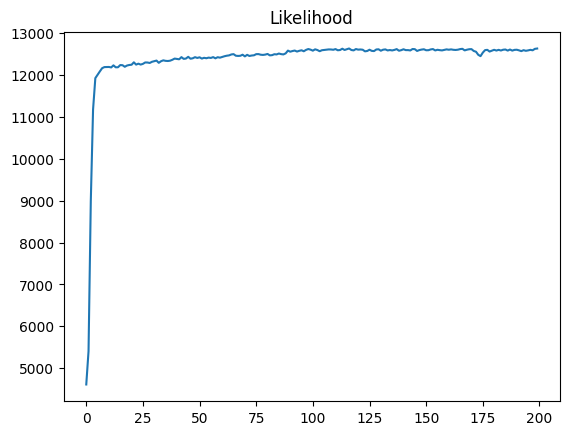

In [ ]:
N_STEPS = 200
N_DOCS = 150
VOCAB_SIZE = 25
SIGMA = .001

model = GibbsSLDA(N_IMGS*N_TOPICS, N_DOCS, VOCAB_SIZE, sigma=SIGMA)
labels = model.fit_transform(X, N_STEPS)
Y_labels, score = util.evaluate(X_labels, labels)
print('Score:', score)
# util.visualize_data(X[:, 1:3], Y_labels, 'Predicted Labels')
util.visualize_log(model.likelihood_log_, 'Likelihood')

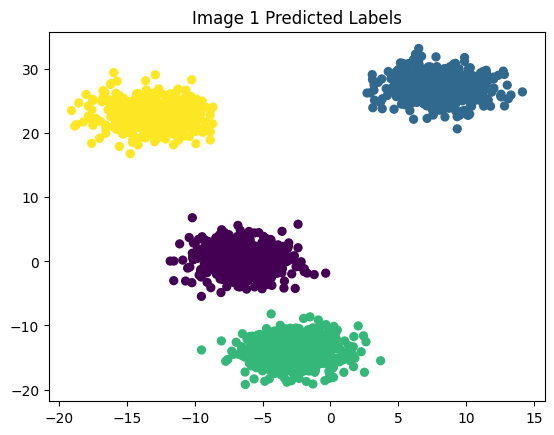

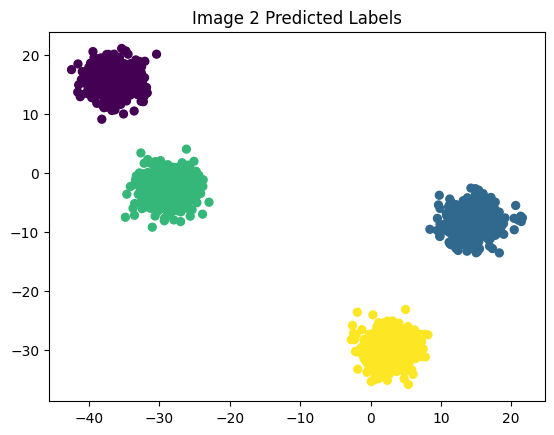

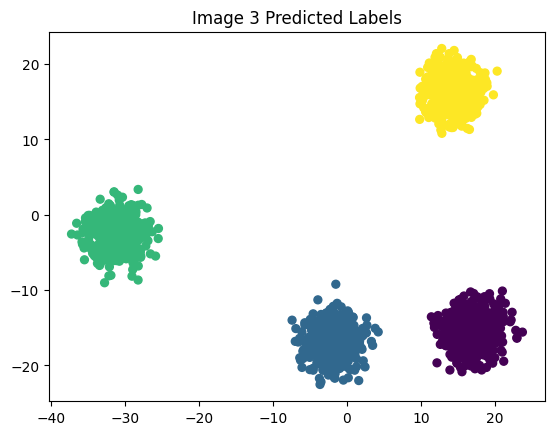

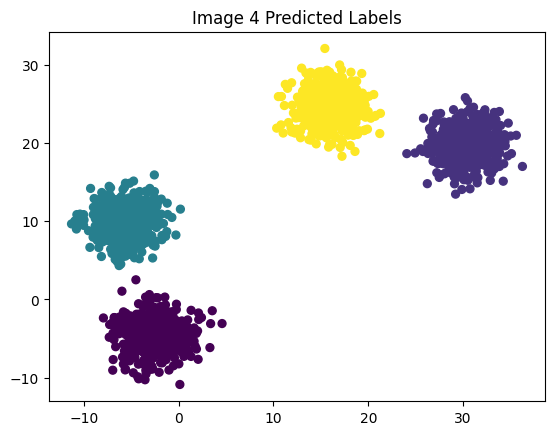

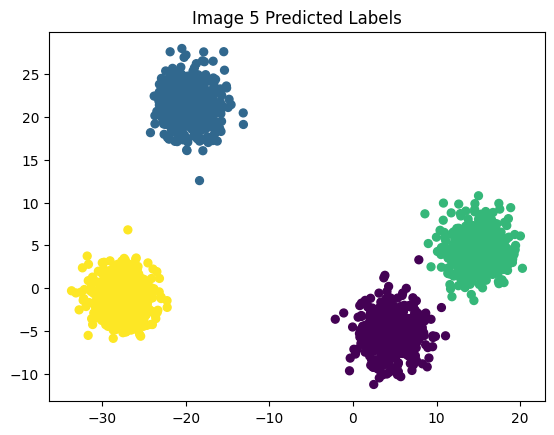

In [ ]:
for i in range(N_IMGS):
    j, k = i*N_SAMPLES, (i + 1)*N_SAMPLES
    util.visualize_data(X[j:k, 1:3], Y_labels[j:k], f'Image {i + 1} Predicted Labels')

## Spine Data

In [ ]:
import muon as mu
import numpy as np
from sklearn.neighbors import NearestNeighbors

def remove_lonely(data, labels, threshold=225., n_neighbors=12):
    locs = data[:, :2]
    knn = NearestNeighbors(n_neighbors=n_neighbors).fit(locs)
    max_dist = knn.kneighbors()[0].max(-1)
    remove_idx, = np.where(max_dist > threshold)
    data = np.delete(data, remove_idx, axis=0)
    labels = np.delete(labels, remove_idx, axis=0)
    return data, labels

def read_spine_data(filename, threshold=225., n_neighbors=12, feature_key='protein', id_key='protein:celltype'):
    mdata = mu.read(filename)
    x, y = mdata['physical'].obsm['spatial'].T
    features = mdata[feature_key].X
    data = np.concatenate([x[None].T, y[None].T, features], -1)
    ids = mdata.obs[id_key]
    labels = np.unique(ids, return_inverse=True)[1]
    if threshold is not None:
        data, labels = remove_lonely(data, labels, threshold, n_neighbors)
    return data, labels

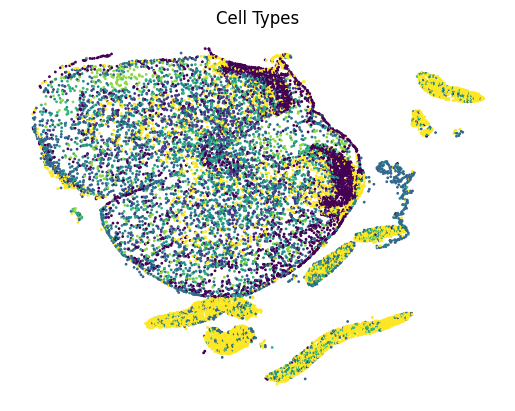

In [ ]:
X, X_labels = read_spine_data('data/m387ntga2.h5mu')
clear_output()
util.visualize_data(X, X_labels, 'Cell Types', size=1, show_ax=False)

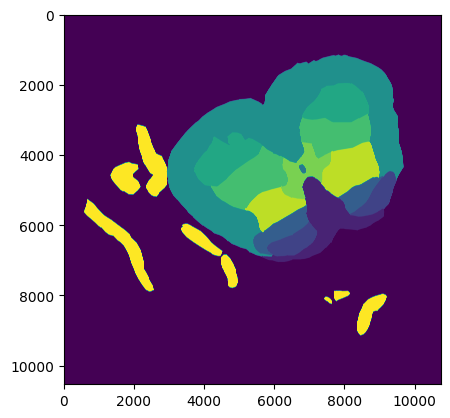

In [ ]:
from skimage import io
import matplotlib.pyplot as plt

img = io.imread('data/m387ntga2.tiff').astype(np.int32)
plt.imshow(img);

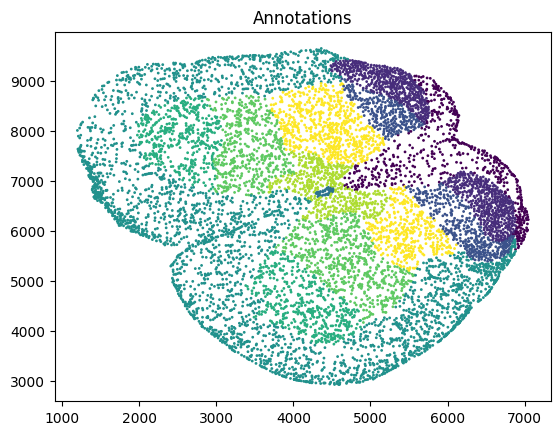

In [ ]:
from scipy import ndimage
from skimage.segmentation import watershed

distance = ndimage.distance_transform_edt(img)
labels = watershed(-distance, 2, mask=img)
X_labels = np.zeros_like(X_labels)
for i in range(X_labels.shape[0]):
    x, y = int(X[i, 0]), int(X[i, 1])
    val = labels[x, y]
    if val > 0:
        X_labels[i] = img[x, y]
X = np.delete(X, np.where(X_labels == 0), 0)
X_labels = np.delete(X_labels, np.where(X_labels == 0), 0)
util.visualize_data(X, X_labels, 'Annotations', size=1)

In [ ]:
N_TOPICS = 9
N_DOCS = 450
VOCAB_SIZE = 50
SIGMA = 100.
N_STEPS = 500

model = GibbsSLDA(N_TOPICS, N_DOCS, VOCAB_SIZE, sigma=SIGMA)
labels = model.fit_transform(X, N_STEPS)
Y_labels, score = util.evaluate(X_labels, labels)
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels', size=1)
util.visualize_log(model.likelihood_log_, 'Likelihood')

3965400


  0%|          | 0/500 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (8815,) (3965400,) 